# Bayesian ARMA model

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer.jl/examples`
    Updating registry at `~/.julia/registries/General.toml`
   Installed RxInfer ─ v2.1.0
    Updating `~/.julia/dev/RxInfer.jl/examples/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
  [336ed68f] + CSV v0.10.7
  [a93c6f00] + DataFrames v1.4.4
  [31c24e10] + Distributions v0.25.79
  [587475ba] + Flux v0.13.9
  [b3f8163a] + GraphPPL v3.1.0
  [429524aa] + Optim v1.7.4
  [d96e819e] + Parameters v0.12.3
  [91a5bcdd] + Plots v1.36.6
  [92933f4c] + ProgressMeter v1.7.2
  [d330b81b] + PyPlot v2.11.0
  [a194aa59] + ReactiveMP v3.0.4
  [37e2e3b7] + ReverseDiff v1.14.4
  [df971d30] + Rocket v1.6.0
  [86711068] + RxInfer v2.1.0
  [276daf66] + SpecialFunctions v2.1.7
  [860ef19b] + StableRNGs v1.0.0
  [4c63d2b9] + StatsFuns v1.1.1
  [f3b207a7] + StatsPlots v0.15.4
⌃ [44d3d7a6] + Weave v0.10.9
    Updating `~/.julia/dev/RxInfer.jl/examples/Manifest.toml`
  [621f4979] + AbstractFFTs v1.2.1
  [7d9f7c33] + Accessors v0.1.22
  [79e6a3ab] + 

  [82ae8749] + StatsAPI v1.5.0
  [2913bbd2] + StatsBase v0.33.21
  [4c63d2b9] + StatsFuns v1.1.1
  [f3b207a7] + StatsPlots v0.15.4
  [69024149] + StringEncodings v0.3.5
  [892a3eda] + StringManipulation v0.3.0
  [09ab397b] + StructArrays v0.6.13
  [ab02a1b2] + TableOperations v1.2.0
  [3783bdb8] + TableTraits v1.0.1
  [bd369af6] + Tables v1.10.0
  [62fd8b95] + TensorCore v0.1.1
  [8290d209] + ThreadingUtilities v0.5.0
  [a759f4b9] + TimerOutputs v0.5.22
  [783c9a47] + TinyHugeNumbers v1.0.0
  [3bb67fe8] + TranscodingStreams v0.9.10
  [28d57a85] + Transducers v0.4.75
  [9d95972d] + TupleTools v1.3.0
  [5c2747f8] + URIs v1.4.1
  [3a884ed6] + UnPack v1.0.2
  [1cfade01] + UnicodeFun v0.4.1
  [9602ed7d] + Unrolled v0.1.4
  [41fe7b60] + Unzip v0.2.0
  [3d5dd08c] + VectorizationBase v0.21.56
  [81def892] + VersionParsing v1.3.0
  [ea10d353] + WeakRefStrings v1.4.2
⌃ [44d3d7a6] + Weave v0.10.9
  [cc8bc4a8] + Widgets v0.6.6
  [efce3f68] + WoodburyMatrices v0.5.5
  [ddb6d928] + YAML v0.4.8
  [e8

This notebook shows how Bayesian [ARMA model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Applications) can be implemeted in **RxInfer.jl**. For theoretical details on Varitional Inference for ARMA model, we refer the reader to the following [paper](https://ieeexplore.ieee.org/document/7798432). The Bayesian ARMA model can be written as follows:


$$\begin{aligned}
e_t \sim \mathcal{N}(0, \gamma^{-1}) \quad
\theta &\sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \quad
\eta \sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \\
\mathbf{h}_0 &\sim \mathcal{MN}\left(\begin{bmatrix}
e_{-1} \\
e_{-2}
\end{bmatrix}, \mathbf{I}\right) \\
\mathbf{h}_t &= \mathbf{S}\mathbf{h}_{t-1} + \mathbf{c} e_{t-1} \\
\mathbf{x}_t &= \boldsymbol{\theta}^\top\mathbf{x}_{t-1} + \boldsymbol{\eta}^\top\mathbf{h}_{t} + e_t 
\end{aligned}$$

where shift matrix $\mathbf{S}$ is

$$\begin{aligned}
\mathbf{S} = \begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}
\end{aligned}$$

and unit vector $\mathbf{c}$: 

$$\begin{aligned}
\mathbf{c}=[1, 0]
\end{aligned}$$ 

when MA order is $2$

In this way, $\mathbf{h}_t$ containing errors $e_t$ can be viewed as hidden state.

In short, the Bayesian ARMA model has two intractabilities: (1) induced by the multiplication of two Gaussian RVs, i.e., $\boldsymbol{\eta}^\top\mathbf{h}_{t}$, (2) induced by errors $e_t$ that prevents analytical update of precision parameter $\gamma$ (this can be easily seen when constructing the Factor Graph, i.e. there is a loop). Both problems can be easily resolved in **RxInfer.jl**, by creating a hybrid inference algorithm based on Loopy Variational Message Passing.

In [2]:
# Load packages
using RxInfer, LinearAlgebra, CSV, DataFrames, Plots

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1664
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [3]:
# Define shift function
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [4]:
@model function ARMA(n, x_prev, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p, q)
        
    c = zeros(p); c[1] = 1.0; # AR
    b = zeros(q); b[1] = 1.0; # MA
    S = shift(q); # MA
    
    # initialize variables
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    
    x  = datavar(Float64, n) where { allow_missing = true }
    
    # priors
    γ  ~ Gamma(shape = shape(γ_prior), rate = rate(γ_prior))
    η  ~ MvNormal(mean = mean(η_prior), precision = precision(η_prior))
    θ  ~ MvNormal(mean = mean(θ_prior), precision = precision(θ_prior))
    τ  ~ Gamma(shape = shape(τ_prior), rate = rate(τ_prior))
    
    # initial
    h_0  ~ MvNormal(mean = mean(h_prior), precision = precision(h_prior))
    z[1] ~ AR(h_0, η, τ) where { meta = ARMeta(Multivariate, q, ARsafe()) }
    e[1] ~ Normal(mean = 0.0, precision = γ)

    x[1] ~ dot(b, z[1]) + dot(θ, x_prev[1]) + e[1]
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t+1] ~ Normal(mean = 0.0, precision = γ)
        h[t] ~ S*h_prev + b*e[t]
        z[t+1] ~ AR(h[t], η, τ) where { meta = ARMeta(Multivariate, q, ARsafe()) }
        x[t+1] ~ dot(z[t+1], b) + dot(θ, x_prev[t]) + e[t+1]
        h_prev = h[t]
    end
end

### Load dataset

To validate our model and inference, we will use American Airlines stock data downloaded from [Kaggle](https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima/data?select=all_stocks_5yr.csv)

Once the dataset is downloaded, we can load it into DataFrame.

In [5]:
x_df = CSV.read("data/arma/aal_stock.csv", DataFrame)

Row,date,open,high,low,close,volume,Name
,Date,Float64,Float64,Float64,Float64,Int64,String3
1,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
3,2013-02-12,14.45,14.51,14.1,14.27,8126000,AAL
4,2013-02-13,14.3,14.94,14.25,14.66,10259500,AAL
5,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
6,2013-02-15,13.93,14.61,13.93,14.5,15628000,AAL
7,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
8,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
9,2013-02-21,13.62,13.95,12.9,13.37,11922100,AAL


In [6]:
# we will use "close" column
x_data = filter(!ismissing, x_df[:, 5]);

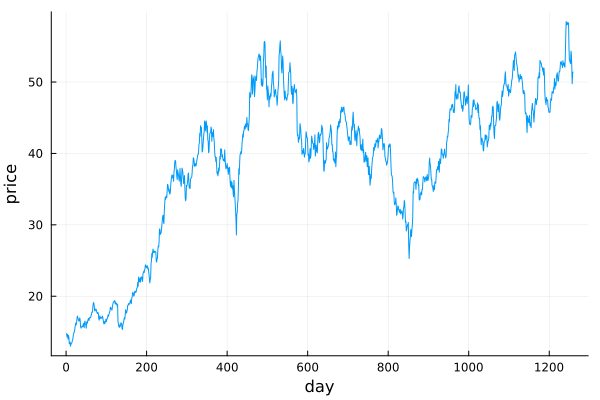

In [7]:
# Plot data
plot(x_data, xlabel="day", ylabel="price", label=false)

In [8]:
p_order = 10 # AR
q_order = 4 # MA

4

In [9]:
# Training set
train_size = 1000
x_prev_train = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][1:train_size]
x_train = Float64.(x_data[p_order+1:end])[1:train_size];

In [10]:
# Test set
x_prev_test = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][train_size+1:end]
x_test = Float64.(x_data[p_order+1:end])[train_size+1:end];

### Inference

In [11]:
# Constraints are needed for performing VMP
arma_constraints = @constraints begin
    q(z, h_0, h, η, τ, γ,e) = q(h_0)q(z, h)q(η)q(τ)q(γ)q(e)
end;

In [12]:
# This cell defines prior knowledge for model parameters
h_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
γ_prior = GammaShapeRate(1e4, 1.0)
τ_prior = GammaShapeRate(1e2, 1.0)
η_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
θ_prior = MvNormalMeanPrecision(zeros(p_order), diageye(p_order));

In [13]:
# Model's graph has structural loops, hence, it requires pre-initialisation
arma_imarginals = (h_0 = h_prior, h = h_prior, γ = γ_prior, τ = τ_prior, η = η_prior, θ = θ_prior);
arma_imessages  = (h_0 = h_prior, h = h_prior);

In [14]:
result = inference(
    model = ARMA(length(x_train), x_prev_train, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p_order, q_order), 
    data  = (x = x_train, ),
    initmarginals = arma_imarginals,
    initmessages  = arma_imessages,
    constraints   = arma_constraints,
    iterations    = 50,
    options       = (limit_stack_depth = 100, ),
);

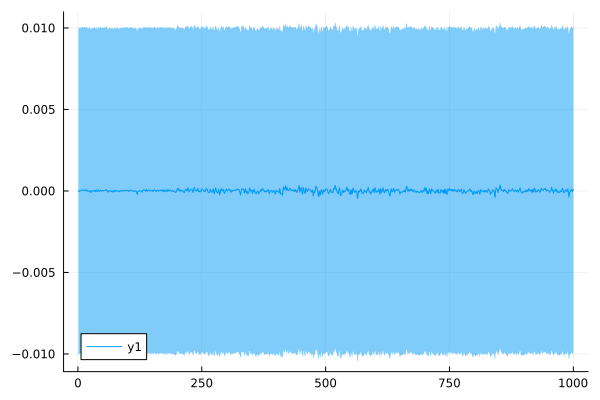

In [15]:
plot(mean.(result.posteriors[:e][end]), ribbon=std.(result.posteriors[:e][end]))

In [16]:
# extract posteriors
h_posterior = result.posteriors[:h][end][end]
γ_posterior = result.posteriors[:γ][end]
τ_posterior = result.posteriors[:τ][end]
η_posterior = result.posteriors[:η][end]
θ_posterior = result.posteriors[:θ][end];

## Prediction

Here we are going to use our inference results in order to predict the dataset itself

In [17]:
# The prediction function is aimed at approximating the predictive posterior distribution
# It triggers the rules in the generative order (in future, RxInfer.jl will provide this function out of the box)
function prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p, q)
    h_out = MvNormalMeanPrecision(mean(h_posterior), precision(h_posterior))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=h_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, p, ARsafe()))
    c = zeros(p); c[1] = 1.0
    b = zeros(q); b[1] = 1.0
    ar_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(b), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    θ_out = MvNormalMeanPrecision(mean(θ_posterior), precision(θ_posterior))
    ma_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(x_prev), m_in2=θ_out, meta=ReactiveMP.TinyCorrection())
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=PointMass(0.0), q_τ=mean(γ_posterior))
    ar_ma = @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_dot_out, m_in2=ma_dot_out)  
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_ma, m_in2=e_out)  
end

prediction (generic function with 1 method)

In [18]:
predictions = []
for x_prev in x_prev_test
    push!(predictions, prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p_order, q_order))
    # after every new prediction we can actually "retrain" the model to use the power of Bayesian approach
    # we will skip this part for now
end

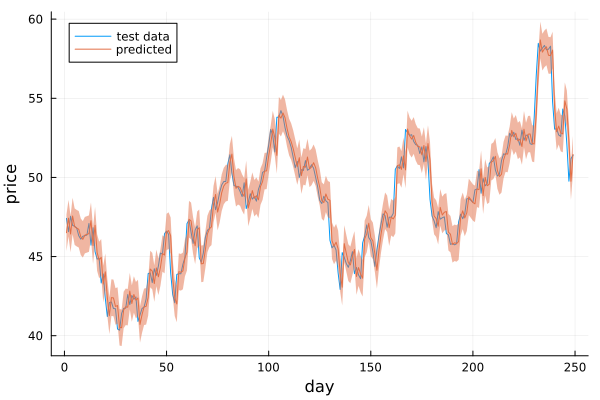

In [19]:
plot(x_test, label="test data", legend=:topleft)
plot!(mean.(predictions)[1:end], ribbon=std.(predictions)[1:end], label="predicted", xlabel="day", ylabel="price")